<h1 align=center><font size = 8>Data Science Capstone Project</font></h1>
<h1 align=center><font size = 8>A Comparison of Dallas and Fort Worth</font></h1>

## Introduction
<blockquote>It is often said that Dallas is where the east ends and Fort Worth is where the west begins.  Certainly, it is true that when you think of Fort Worth, you think of pickup trucks and cowboy boots and Billy Bob's at The Stockyards and when you think of Dallas, you think of BMW's and banking and Highland Park.  The question for someone who's company has recently moved to the DFW area, though, is:  is there a difference in the neighborhoods in Fort Worth and Dallas?</blockquote>
<blockquote>This project will use Zillow nighborhood data to see if there are any systematic differences in Dallas vs. Fort Worth nighborhoods using k-means clustering.</blockquote>

We will start by loading the libraries that we need for this project.

In [221]:
try:
    import pandas as pd
    import numpy as np
except:
    !conda install -c anaconda pandas numpy --yes 
    import pandas as pd
    import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
try:
    from geopy.geocoders import Nominatim # to convert address into latitude and longitude
except:
    !conda install -c conda-forge geopy --yes 
    from geopy.geocoders import Nominatim
try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium --yes 
    import folium
from bs4 import BeautifulSoup
import urllib.request
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import geojson
!conda activate geo1
from shapely.geometry import Point, Polygon

In [222]:
!conda activate geo1
from shapely.geometry import Point, Polygon

## Data
The geodata used for this project is the Zillow US Neighborhoods dataset.  Zillow makes this data available for free under a creative commons licence.  It can be downloaded at "https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/".
<br>
<br>
We used the export filters and downloaded one geojson file for Fort Worth and a second geojson file for Dallas.  The files contain full geoshape data and has "properties" sections that that contain the city, neighborhood name, regionid, geo_point_2d, county and state.  We parse the files to just load the properties section and append it to a dataframe.  We then split the geo_data_2d entry into Latitude and Longitude columns, dropping any rows where geo_data_2d is NA.


In [223]:
with open('e:/downloads/zillow-neighborhoods-FortWorth.geojson') as json_data:
    fortworth_neighborhood_data = geojson.load(json_data)
with open('e:/downloads/zillow-neighborhoods-Dallas.geojson') as json_data:
    dallas_neighborhood_data = geojson.load(json_data)
print(type(fortworth_neighborhood_data), type(dallas_neighborhood_data))

<class 'geojson.feature.FeatureCollection'> <class 'geojson.feature.FeatureCollection'>


In [224]:
print(type(fortworth_neighborhood_data[0]['geometry']['coordinates'][0]))
print(fortworth_neighborhood_data[0]['geometry']['coordinates'][0])
print(fortworth_neighborhood_data['features'][0])

<class 'list'>
[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]
{"geometry": {"coordinates": [[[-97.428271, 32.645946], [-97.428288, 32.645946], [-97.428367, 32.645944], [-97.428685, 32.645933], [-97.429647, 32.645984], [-97.4302, 32.646044], [-97.430962, 32.646061], [-97.432542, 32.646125], [-97.43244, 32.648147], [-97.428821, 32.648459], [-97.428535, 32.647886], [-97.428396, 32.647557], [-97.428318, 32.647253], [-97.428249, 32.646923], [-97.42824, 32.646541], [-97.428271, 32.645946]]], "type": "Polygon"}, "properties": {"city": "Fort Worth", "county": "Tarrant", "geo_point_2d": [32.64714146486756, -97.43035652827258], "name": "Briercliff", "r

In [225]:
fortworth_neighborhood_data_slice = fortworth_neighborhood_data['features']
df = pd.DataFrame(columns=['city','name','regionid','geo_point_2d','county','state'])
df_coordinates = pd.DataFrame(columns=['coordinates'])
for entry in fortworth_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
dallas_neighborhood_data_slice = dallas_neighborhood_data['features']
for entry in dallas_neighborhood_data_slice:
    df = df.append(entry['properties'],ignore_index=True)
    df_coordinates = df_coordinates.append(entry['geometry'],ignore_index=True)
df = df.rename(columns={'name': 'Neighborhood'})
df['coordinates']=df_coordinates['coordinates']
df.head()

,city,Neighborhood,regionid,geo_point_2d,county,state,coordinates
0,Fort Worth,Briercliff,422763,"[32.64714146486756, -97.43035652827258]",Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645..."
1,Fort Worth,Fairmount,233172,"[32.724372978687654, -97.33766189387364]",Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804..."
2,Fort Worth,Willow Creek,207722,"[32.63110091743264, -97.3434603767844]",Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348..."
3,Fort Worth,Shaw Clarke,422871,"[32.70111450603923, -97.33719612060821]",Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724..."
4,Fort Worth,Carver Heights,422820,"[32.72505076405124, -97.22932078449055]",Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725..."


Split up geo_point_2d into Latitude and Longitude

In [226]:
print(df.shape)
df = df.dropna(subset=['geo_point_2d'])
print(df.shape)
df2 = pd.DataFrame(df["geo_point_2d"].tolist(), columns=['Latitude','Longitude']) #pd.DataFrame(df['geo_point_2d'].tolist(),index=df.index)
df = pd.concat([df, df2], axis=1)
df.drop(['geo_point_2d','regionid'],axis=1,inplace=True)
df.head()

(425, 7)
(425, 7)


,city,Neighborhood,county,state,coordinates,Latitude,Longitude
0,Fort Worth,Briercliff,Tarrant,TX,"[[[-97.428271, 32.645946], [-97.428288, 32.645...",32.647141,-97.430357
1,Fort Worth,Fairmount,Tarrant,TX,"[[[-97.34377, 32.718042], [-97.34377, 32.71804...",32.724373,-97.337662
2,Fort Worth,Willow Creek,Tarrant,TX,"[[[-97.348532, 32.634888], [-97.34777, 32.6348...",32.631101,-97.343460
3,Fort Worth,Shaw Clarke,Tarrant,TX,"[[[-97.33749, 32.70601], [-97.33749, 32.705724...",32.701115,-97.337196
4,Fort Worth,Carver Heights,Tarrant,TX,"[[[-97.228473, 32.725718], [-97.228222, 32.725...",32.725051,-97.229321


Extract Dallas-Fort Worth

In [227]:
#dfw = df[df['city'].isin(['Dallas', 'Fort Worth'])]
dfw = df
dfw.sort_values(['city','Neighborhood'], inplace=True, ignore_index=True)
print(dfw.shape)
dfw.groupby("city").count()

(425, 7)


,Neighborhood,county,state,coordinates,Latitude,Longitude
city,,,,,,
Carrollton,21,21,21,21,21,21
Dallas,34,34,34,34,34,34
Desoto,6,6,6,6,6,6
Fort Worth,225,225,225,225,225,225
Garland,85,85,85,85,85,85
Irving,18,18,18,18,18,18
Mesquite,4,4,4,4,4,4
Plano,1,1,1,1,1,1
Richardson,31,31,31,31,31,31


# Methodology
##  Visual Inspection:  Create a map of DFW Neighborhoods

In [228]:
# create map - use Arlington for map lat/long
address = 'Arlington, TX'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Arlington are {}, {}.'.format(latitude, longitude))
# using point slightly north to get centering right
latitude =32.791825
longitude = -97.03

The geograpical coordinate of Arlington are 32.701938999999996, -97.10562379033699.


In [229]:
# create map of DFW using latitude and longitude values for Arlington
map_dfw = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, city, neighborhood in zip(dfw['Latitude'], dfw['Longitude'], dfw['city'], df['Neighborhood']):
    label = '{}, {}, {}, {}'.format(neighborhood, city, lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dfw)  
    
map_dfw

# Get Neighborhood Venues

In [230]:
CLIENT_ID = 'YPF4NY2VJMYEMROHWYBYVI11IZKQ0H4EDECKGJR0XDYRWE4M' # your Foursquare ID
CLIENT_SECRET = 'LI202HN0RHIHWIIQQPWSYIPUQE14DLGSNALI21B5XGV4E31Y' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1200 #1600 approx 1 mile, 500 approx .3 mile

In [231]:
def getVenuesInPolygon(names, latitudes, longitudes, polygons):
    file_handle=open('coordinates.csv','w')
    radius=3200
    venues_list=[]
    for name, lat, lng, poly in zip(names, latitudes, longitudes, polygons):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #try:    
        # make the GET request
        #results = requests.get(url).json()["response"]['groups'][0]['items']
        results = requests.get(url).json()["response"]
        if len(results)>0:
            results = results['groups'][0]['items']
            while len(poly)>0 and len(poly)<3:
                poly = poly[0]
            try:
                coordinates = Polygon(poly)
            except:
                try:
                    coordinates = Polygon(poly[0])
                except:
                    try:
                        coordinates = Polygon(poly[0][0])
                    except:
                        print(name," Invalid coordinates: length: ",len(poly),' coordinates: ', poly)
                        file_handle.write(name," Invalid coordinates: length: ",len(poly),' coordinates: ')
                        file_handle.write(poly)            
            # return only relevant information for each nearby venue
            #print(results)
            venue_count = 0
            for v in results:
                pt = Point([v['venue']['location']['lng'],v['venue']['location']['lat']])
                #if (coordinates.length>0 and pt.within(coordinates)) or (coordinates.length==0 and v['venue']['location']['distance']<800):
                if (coordinates.length>0 and pt.within(coordinates)) or v['venue']['location']['distance']<800:
                    venue_count = venue_count + 1
                    #print(pt,' inside ',coordinates)
                    venues_list.append([name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']])
                #else:
                #    print(pt,' outside ',coordinates)
            print(name, lat, lng, ' venue count ', venue_count)            
            if venue_count==0:
                print('\tno venues')
                venues_list.append([
                    name, 
                lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
            
        else:
            print(name, lat, lng,' No groups in results')
            venues_list.append([
                    name, 
                    lat, 
                    lng, 
                    'Residential', 
                    lat, 
                    lng,  
                    'Residential'
                    ])
                  
        #except:
        #    print('\tProblem getting info')
    #print('venues_list:  ',venues_list)  
    nearby_venues = pd.DataFrame(venues_list, columns=['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 
        'Venue Longitude', 'Venue Category']) 
    #nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    #nearby_venues = pd.DataFrame(columns = ['Neighborhood', 
    #              'Neighborhood Latitude', 
    #              'Neighborhood Longitude', 
    #              'Venue', 
    #              'Venue Latitude', 
    #              'Venue Longitude', 
    #              'Venue Category'])
    file_handle.close()
    return(nearby_venues)

In [232]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:    
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('\tProblem getting info')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [233]:
#dfw_venues = getNearbyVenues(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],radius)
#print(dfw['coordinates'].iloc[:5])
radius=3200
#dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'].iloc[:5],latitudes=dfw['Latitude'].iloc[:5],longitudes=dfw['Longitude'].iloc[:5],
#    polygons=dfw['coordinates'].iloc[:5])
dfw_venues = getVenuesInPolygon(names=dfw['Neighborhood'],latitudes=dfw['Latitude'],longitudes=dfw['Longitude'],polygons=dfw['coordinates'])
#print (dfw_venues.head())
print('There are {} unique categories.'.format(len(dfw_venues['Venue Category'].unique())))

Bel Air of Josey Ranch 32.969355914257726 -96.88168631227494  venue count  3
Cambridge Estates 32.988927644291394 -96.91617820375673  venue count  16
Carrollton Heights 32.956817736977484 -96.90127455361676  venue count  8
Carrollton Summertree 32.97278590625278 -96.86834792754553  venue count  1
Carrolton Highlands 32.951421190068444 -96.89745971865148  venue count  5
Hill'n Dale 32.9652324227805 -96.89314077922661  venue count  1
Jackson Arms 32.97657242364724 -96.89296428247056  venue count  6
Mcoy Estates 32.98105765762574 -96.89554645640186  venue count  4
Morningside 32.98840829897419 -96.87152296182454  venue count  1
Nob Hill 32.98963477794778 -96.89570633349281  venue count  6
Oak Tree North 32.98817469682512 -96.86008121492931  venue count  5
Park Terrace 32.96294828979307 -96.9049947817715  venue count  0
	no venues
Parks of Carrollton 32.97653456989962 -96.9022608953078  venue count  7
Parkside Estates 32.97768723189802 -96.87202308761685  venue count  1
Rohton Park 32.9500

In [234]:
dfw_venues.loc[dfw_venues['Venue Category']=='Zoo Exhibit']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1461,Berkeley Place,32.721110,-97.349059,The Texas Wild,32.717984,-97.353705,Zoo Exhibit
1463,Berkeley Place,32.721110,-97.349059,Penguins,32.719308,-97.354746,Zoo Exhibit
1786,Frisco Heights,32.711151,-97.354355,The Texas Wild,32.717984,-97.353705,Zoo Exhibit
2091,Park Hill,32.718465,-97.358118,The Texas Wild,32.717984,-97.353705,Zoo Exhibit
2353,University Place,32.713866,-97.358543,The Texas Wild,32.717984,-97.353705,Zoo Exhibit


In [235]:
# load and merge Venue Groups
venue_groups = pd.read_csv('VenueGroups.csv')
venue_groups.head()
if 'Venue Group' in dfw_venues.columns:
    dfw_venues.drop('Venue Group',axis=1, inplace=True)
dfw_venues = dfw_venues.join(venue_groups.set_index('Venue Category'), on='Venue Category')
dfw_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,Bel Air of Josey Ranch,32.969356,-96.881686,Braum's Ice Cream & Dairy Store,32.972006,-96.889480,Ice Cream Shop,Fast-Food Venue
1,Bel Air of Josey Ranch,32.969356,-96.881686,The Home Depot,32.973511,-96.886881,Hardware Store,Home Shop
2,Bel Air of Josey Ranch,32.969356,-96.881686,Pizza Hut,32.971590,-96.877311,Pizza Place,Fast-Food Venue
3,Cambridge Estates,32.988928,-96.916178,Super H-Mart,32.984990,-96.911966,Supermarket,Grocery Store
4,Cambridge Estates,32.988928,-96.916178,Chick-fil-A,32.986170,-96.909283,Fast Food Restaurant,Fast-Food Venue


In [338]:
dfw_venues[dfw_venues['Venue Category']=='Discount Store']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
209,Buckner Terrace,32.785893,-96.702297,Family Dollar,32.791255,-96.698271,Discount Store,Shopping Venues
214,Cedar Crest,32.718310,-96.788708,Dollar General,32.741723,-96.789089,Discount Store,Shopping Venues
220,Cedar Crest,32.718310,-96.788708,Family Dollar,32.708535,-96.800264,Discount Store,Shopping Venues
222,Cedar Crest,32.718310,-96.788708,Family Dollar,32.717546,-96.776881,Discount Store,Shopping Venues
226,Cedar Crest,32.718310,-96.788708,Family Dollar,32.726631,-96.811681,Discount Store,Shopping Venues
232,Cedar Crest,32.718310,-96.788708,Family Dollar,32.694819,-96.773287,Discount Store,Shopping Venues
446,Five Mile Creek,32.696882,-96.831891,Dollar General,32.696537,-96.839050,Discount Store,Shopping Venues
451,Five Mile Creek,32.696882,-96.831891,Family Dollar,32.695911,-96.841080,Discount Store,Shopping Venues
537,Lake Highlands,32.893643,-96.754631,Nordstrom Rack,32.868091,-96.769055,Discount Store,Shopping Venues
810,Northeast Dallas,32.845409,-96.714138,Dollar Tree,32.834805,-96.702150,Discount Store,Shopping Venues


In [237]:
# make sure all venue categories have been assigned to venue groups
dfw_venues[dfw_venues['Venue Group']=='']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group


In [238]:
print(dfw_venues.groupby('Neighborhood').count())

Neighborhood Latitude  \
Neighborhood                                               
Alamo Heights                                          9   
Alexandra Meadows                                      1   
Almeta,Bonita, Bella Vista                             1   
Altemesa East                                          2   
Apollo Arapaho & Camelot                               5   
Arapaho                                                6   
Arbor Creek                                            1   
Arcadia Park                                           5   
Arlington Heights                                      1   
Arts District                                         31   
Avondale                                              12   
Bal Harbour                                            2   
Basswood Park                                          1   
Basswood Village                                       1   
Bear Creek                                            34   
Beechwood Creek

# Analyze Neighborhoods

In [239]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Category']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_onehot.head()

No venues called Neighborhood


,Neighborhood,ATM,Adult Boutique,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Country Dance Club,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bel Air of Josey Ranch,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [240]:
dfw_grouped = dfw_onehot.groupby('Neighborhood').mean().reset_index()
dfw_grouped.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Big Box Store,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Station,Butcher,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Bookstore,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Country Dance Club,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Electronics Store,Ethiopian Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,History Museum,Hobby Shop,Hockey Rink,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Internet Cafe,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Public Art,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residential,Residential Building (Apartment / Condo),Resort,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alamo Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0

# Group most common venues in each neighborhood

In [294]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
top_venue_columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        top_venue_columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped['Neighborhood']

for ind in np.arange(dfw_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alamo Heights,Grocery Store,Coffee Shop,Fast Food Restaurant,Sushi Restaurant,Burger Joint,Diner,Vietnamese Restaurant,Dessert Shop,BBQ Joint,NA
1,Alexandra Meadows,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,"Almeta,Bonita, Bella Vista",American Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,Altemesa East,Cosmetics Shop,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA
4,Apollo Arapaho & Camelot,Video Store,Pizza Place,Butcher,Sports Bar,Chinese Restaurant,NA,NA,NA,NA,NA


In [295]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 6

dfw_grouped_clustering = dfw_grouped.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dfw_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged = dfw

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfw_merged = dfw_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfw_merged.head()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,Dallas,TX,"[[[-96.884675, 32.967425], [-96.884703, 32.969...",32.969356,-96.881686,4,Ice Cream Shop,Pizza Place,Hardware Store,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,Dallas,TX,"[[[-96.913294, 32.990296], [-96.910004, 32.990...",32.988928,-96.916178,4,Korean Restaurant,Bakery,Coffee Shop,Athletics & Sports,Fast Food Restaurant,Bubble Tea Shop,Ice Cream Shop,Indian Restaurant,Seafood Restaurant,Dessert Shop
2,Carrollton,Carrollton Heights,Dallas,TX,"[[[-96.906652, 32.955414], [-96.906635, 32.956...",32.956818,-96.901275,4,Southern / Soul Food Restaurant,Burger Joint,Café,Brewery,Donut Shop,American Restaurant,History Museum,Diner,NA,NA
3,Carrollton,Carrollton Summertree,Dallas,TX,"[[[-96.864348, 32.97025], [-96.867828, 32.9702...",32.972786,-96.868348,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,Dallas,TX,"[[[-96.890407, 32.95367], [-96.890393, 32.9496...",32.951421,-96.897460,4,Donut Shop,History Museum,Burger Joint,Greek Restaurant,Recreation Center,NA,NA,NA,NA,NA


## check for invalid cluster labels

In [296]:
idx = pd.to_numeric(dfw_merged['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged[idx]), ' out of ',len(dfw_merged.index))
#neighborhoods_venues_sorted[idx]

dfw_merged[idx]

Number of neighborhoods with invalid Clusters:  0  out of  425


,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Map clusters--removing rows with invalid cluster labels and converting cluster labels to int before we map them

In [297]:

# first, we have to drop non-numeric clusters and change them to int
dfw_merged = dfw_merged[pd.to_numeric(dfw_merged['Cluster'], errors='coerce').notnull()]
dfw_merged['Cluster'] = dfw_merged['Cluster'].astype('int')
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow2=['#0000ff','#800080','#ff964f','#ff0000','#008000','#ffd700','#1996f3','#663300','#ffc0cb','#daa520','#ff00ff','#9efd38'] 
rainbow_text=['blue','purple','orange','red','green','yellow','sky blue','brown','pink','gold','fuchsia','lime']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged['Latitude'], dfw_merged['Longitude'], dfw_merged['Neighborhood'], dfw_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Category</b></h3>
            '''
map_clusters.get_root().html.add_child(folium.Element(title_html))
map_clusters.save('DFW_by_VenueCategory.html') 
map_clusters

## Examine cluster composition

In [298]:
dfw_merged.groupby('Cluster').count()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,,,,,,,
0,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70
1,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
2,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
3,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
4,284,284,284,284,284,284,284,284,284,284,284,284,284,284,284,284,284
5,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [299]:
# write clusters to html files
for f in range(kclusters):
    fname = "Cluster-ByCategory-" + str(f) + "-" + str(kclusters) + ".html"
    fst_venue_col = 7
    cluster_df = dfw_merged.loc[dfw_merged['Cluster'] == f, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])
    with  open(fname,"w") as file_handle:
        file_handle.write(cluster_df.to_html())

In [300]:
dfw_merged.loc[dfw_merged['Neighborhood']=='Wolf Creek']

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
54,Dallas,Wolf Creek,Dallas,TX,"[[[-96.823164, 32.654073], [-96.823078, 32.641...",32.6584,-96.846397,4,Fast Food Restaurant,Discount Store,Fried Chicken Joint,BBQ Joint,Mexican Restaurant,Smoothie Shop,Grocery Store,Big Box Store,Pharmacy,Chinese Restaurant


In [301]:
fst_venue_col = 7
dfw_merged.loc[dfw_merged['Cluster'] == 0, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Carrollton,Park Terrace,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
56,Desoto,Candel Meadow,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
59,Desoto,Meadowbrook Estates,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
62,Fort Worth,Alexandra Meadows,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
65,Fort Worth,Arlington Heights,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
67,Fort Worth,Basswood Park,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
79,Fort Worth,Briercliff,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
80,Fort Worth,Brittany Place,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
81,Fort Worth,Brookside,0,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [302]:
dfw_merged.loc[dfw_merged['Cluster'] == 1, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Fort Worth,Basswood Village,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
138,Fort Worth,Greenfield Acres,1,Convenience Store,Gym / Fitness Center,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
172,Fort Worth,Marine Creek Hills,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
173,Fort Worth,Marine Creek Ranch,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
191,Fort Worth,Northbrook,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
203,Fort Worth,Parkview Hills,1,Convenience Store,Video Store,NA,NA,NA,NA,NA,NA,NA,NA
211,Fort Worth,Ridglea,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
280,Fort Worth,Westpoint,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
282,Fort Worth,White Lake Hills,1,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [303]:
dfw_merged.loc[dfw_merged['Cluster'] == 2, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Carrollton,Oak Tree North,2,South American Restaurant,Pool,Bar,Gym,Mexican Restaurant,NA,NA,NA,NA,NA
77,Fort Worth,Brentmoor,2,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA,NA
145,Fort Worth,Harmony,2,Convenience Store,Gym,Storage Facility,Mexican Restaurant,NA,NA,NA,NA,NA,NA
149,Fort Worth,Heritage,2,Mexican Restaurant,Convenience Store,Deli / Bodega,Tanning Salon,Greek Restaurant,Grocery Store,Gym,Recreation Center,Chinese Restaurant,Pet Store
150,Fort Worth,Heritage Glen,2,Convenience Store,Mexican Restaurant,Recreation Center,NA,NA,NA,NA,NA,NA,NA
156,Fort Worth,Hubbard Heights,2,Pharmacy,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA,NA
174,Fort Worth,Marine Park,2,Mexican Restaurant,Mediterranean Restaurant,NA,NA,NA,NA,NA,NA,NA,NA
190,Fort Worth,North Side,2,Bar,Mexican Restaurant,Nightclub,Fried Chicken Joint,Café,American Restaurant,Shoe Store,NA,NA,NA
220,Fort Worth,Rosemont,2,Taco Place,Pharmacy,Mexican Restaurant,NA,NA,NA,NA,NA,NA,NA
225,Fort Worth,Scenic Bluff,2,Mexican Restaurant,Bar,Concert Hall,Dive Bar,Italian Restaurant,NA,NA,NA,NA,NA


In [304]:
dfw_merged.loc[dfw_merged['Cluster'] == 3, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Fort Worth,Altemesa East,3,Cosmetics Shop,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA
101,Fort Worth,Cobblestone,3,Gas Station,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA
107,Fort Worth,Crawford Farms,3,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
115,Fort Worth,Eastern Hills,3,Discount Store,Lounge,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,3,Discount Store,Fried Chicken Joint,Pharmacy,NA,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,3,Discount Store,Fried Chicken Joint,NA,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,3,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
186,Fort Worth,North Beverly Hills,3,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
193,Fort Worth,Oakridge Terrace,3,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
232,Fort Worth,South Edgewood,3,Grocery Store,Discount Store,NA,NA,NA,NA,NA,NA,NA,NA


In [305]:
dfw_merged.loc[dfw_merged['Cluster'] == 4, dfw_merged.columns[[0,1] + list(range(6, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,-96.881686,4,Ice Cream Shop,Pizza Place,Hardware Store,NA,NA,NA,NA,NA,NA,NA
1,Carrollton,Cambridge Estates,-96.916178,4,Korean Restaurant,Bakery,Coffee Shop,Athletics & Sports,Fast Food Restaurant,Bubble Tea Shop,Ice Cream Shop,Indian Restaurant,Seafood Restaurant,Dessert Shop
2,Carrollton,Carrollton Heights,-96.901275,4,Southern / Soul Food Restaurant,Burger Joint,Café,Brewery,Donut Shop,American Restaurant,History Museum,Diner,NA,NA
3,Carrollton,Carrollton Summertree,-96.868348,4,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,-96.897460,4,Donut Shop,History Museum,Burger Joint,Greek Restaurant,Recreation Center,NA,NA,NA,NA,NA
5,Carrollton,Hill'n Dale,-96.893141,4,Bookstore,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,Carrollton,Jackson Arms,-96.892964,4,Pizza Place,Ice Cream Shop,Sandwich Place,Mexican Restaurant,Juice Bar,Hardware Store,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,-96.895546,4,Donut Shop,Trail,Sandwich Place,Coffee Shop,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,-96.871523,4,Grocery Store,Ice Cream Shop,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,-96.895706,4,Cosmetics Shop,Sandwich Place,Tex-Mex Restaurant,Trail,Supermarket,Cuban Restaurant,NA,NA,NA,NA


In [306]:
dfw_merged.loc[dfw_merged['Cluster'] == 5, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Fort Worth,Beechwood Creek,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
71,Fort Worth,Bently Village,5,Golf Course,Hardware Store,NA,NA,NA,NA,NA,NA,NA,NA
102,Fort Worth,Colonial Hills,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,5,Furniture / Home Store,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
321,Garland,Greens,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
324,Garland,Hills of Firewheel,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
339,Garland,Oakridge,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
350,Garland,Retreat at Firewheel,5,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [307]:
dfw_merged.loc[dfw_merged['Cluster'] == 6, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [308]:
dfw_merged.loc[dfw_merged['Cluster'] == 7, dfw_merged.columns[[0,1] + list(range(fst_venue_col, dfw_merged.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


## Analyze Neighborhoods by Venue Group

In [309]:
# one hot encoding
dfw_onehot = pd.get_dummies(dfw_venues[['Venue Group']], prefix="", prefix_sep="")
# There is Neighborhood in the venue categories, so we drop that column
try:
    del dfw_onehot['Neighborhood']
except:
    print('No venues called Neighborhood')
# add neighborhood column back to dataframe
dfw_onehot['Neighborhood'] = dfw_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dfw_onehot.columns[-1]] + list(dfw_onehot.columns[:-1])
dfw_onehot = dfw_onehot[fixed_columns]
dfw_grouped2 = dfw_onehot.groupby('Neighborhood').mean().reset_index()
neighborhoods_venues_sorted = pd.DataFrame(columns=top_venue_columns)
neighborhoods_venues_sorted['Neighborhood'] = dfw_grouped2['Neighborhood']

for ind in np.arange(dfw_grouped2.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dfw_grouped2.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if dfw_grouped2.set_index('Neighborhood').loc[[neighborhoods_venues_sorted.iloc[ind, 0]],[neighborhoods_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            neighborhoods_venues_sorted.iloc[ind, 1+col] = 'NA'
# cluster analysis
dfw_grouped_clustering_bygroup = dfw_grouped2.drop('Neighborhood', axis=1)
if 'Cluster' in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.drop('Cluster',axis=1, inplace=True)
# run k-means clustering
kclusters2 = 9
kmeans = KMeans(n_clusters=kclusters2, random_state=0).fit(dfw_grouped_clustering_bygroup)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)
dfw_merged_bygroup = dfw

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfw_merged_bygroup = dfw_merged_bygroup.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dfw_merged_bygroup.head() # check the last columns!
idx = pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').isna()
print('Number of neighborhoods with invalid Clusters: ',len(dfw_merged_bygroup[idx]), ' out of ',len(dfw_merged_bygroup.index))
print(neighborhoods_venues_sorted[idx])



No venues called Neighborhood
Number of neighborhoods with invalid Clusters:  0  out of  425
Empty DataFrame
Columns: [Cluster, Neighborhood, 1st Most Common Venue, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue]
Index: []


In [310]:
# venue groups to html file
fname = "VenueGroups.html"
with  open(fname,"w") as file_handle:
    file_handle.write(venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).to_html())
#venue_groups.head()
#venue_groups[['Venue Group', 'Venue Category']].sort_values(['Venue Group', 'Venue Category']).head()

In [311]:
# Create the map
# first, we have to drop non-numeric clusters and change them to int
dfw_merged_bygroup = dfw_merged_bygroup[pd.to_numeric(dfw_merged_bygroup['Cluster'], errors='coerce').notnull()]
dfw_merged_bygroup['Cluster'] = dfw_merged_bygroup['Cluster'].astype('int')
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfw_merged_bygroup['Latitude'], dfw_merged_bygroup['Longitude'], dfw_merged_bygroup['Neighborhood'], dfw_merged_bygroup['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow2[cluster],
        fill=True,
        fill_color=rainbow2[cluster],
        fill_opacity=0.7).add_to(map_clusters2)
title_html = '''
            <h3 align="center" style="font-size:20px"><b>DFW Neighborhoods by Venue Group - ''' + str(kclusters2) + ''' Clusters</b></h3>
            '''
map_clusters2.get_root().html.add_child(folium.Element(title_html))

map_clusters2.save('DFW_by_VenueGroup-' + str(kclusters2) + '.html')      
map_clusters2

## Examine cluster composition

In [312]:
dfw_merged_bygroup.groupby('Cluster').count()

,city,Neighborhood,county,state,coordinates,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster,,,,,,,,,,,,,,,,,
0,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
1,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70
2,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162
3,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
4,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
5,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
7,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
8,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


In [313]:
color_df = pd.DataFrame(rainbow_text)
color_df.columns = ['Color']
color_df['Cluster'] = color_df.index
color_df

,Color,Cluster
0,blue,0
1,purple,1
2,orange,2
3,red,3
4,green,4
5,yellow,5
6,sky blue,6
7,brown,7
8,pink,8
9,gold,9


In [314]:

cluster_count = pd.DataFrame(dfw_merged_bygroup.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
cluster_count.columns = ['Count By Group']
cluster_count = cluster_count.merge(color_df, left_index=True, right_index=True)
#count_bygroup['File'] = "Cluster-" +str(count_bygroup['Cluster']) + '.html'
#del cluster_count['Cluster']
#cluster_count
df = pd.DataFrame(dfw_merged.groupby('Cluster')['city'].count())
#cluster_count['CountByGroup']=cluster_count['city']
df.columns = ['Count By Category']
cluster_count = cluster_count.merge(df, left_index=True, right_index=True)
cluster_count = cluster_count[['Cluster','Color', 'Count By Category', 'Count By Group']]
cluster_count.reset_index(inplace=True)
#cluster_count.assign(GroupFile = "Cluster-" + str(cluster_count.index) + "-" + str(kclusters2) + ".html")
cluster_count['Category File'] = cluster_count.apply(lambda row: '<a href="Cluster-ByCategory-' + str(row.Cluster) + '-' + str(kclusters) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + ' neighborhoods</a>',axis=1)
cluster_count['Group File'] = cluster_count.apply(lambda row: '<a href="Cluster-ByGroup-' + str(row.Cluster) + '-' + str(kclusters2) + '.html"'  + 'target="_blank">Cluster ' + str(row.Cluster) + ' neighborhoods</a>',axis=1)
print(dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 1,'1st Most Common Venue'].value_counts().idxmax())
cluster_count['Group Desc'] = ''
cluster_count['Category Desc']=''
for f in range(kclusters2): 
    #print(f,dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f,'1st Most Common Venue'].value_counts().idxmax())
    cluster_count.at[f,'Group Desc'] = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f,'1st Most Common Venue'].value_counts().idxmax()
    cluster_count.at[f,'Category Desc'] = dfw_merged.loc[dfw_merged['Cluster'] == f,'1st Most Common Venue'].value_counts().idxmax()
cluster_count = cluster_count[['Cluster','Color', 'Count By Category','Category Desc', 'Category File', 'Count By Group', 'Group Desc', 'Group File']]
#cluster_count['Group_Descr'] = cluster_count.apply(lambda row: dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == int(row.Cluster),'1st Most Common Venue'].value_counts().idxmax())
fname = "Cluster_Table.html"
with  open(fname,"w") as file_handle:
        file_handle.write(cluster_count.to_html(index=False, justify="center",classes="table table-bordered",escape=False))
cluster_count

Residential


ValueError: attempt to get argmax of an empty sequence

In [315]:
cluster_count.head()

,index,Cluster,Color,Count By Category,Count By Group,Category File,Group File,Group Desc,Category Desc
0,0.0,0.0,blue,70.0,98.0,"<a href=""Cluster-ByCategory-0-6.html""target=""_...","<a href=""Cluster-ByGroup-0-9.html""target=""_bla...",Mexican Cuisine,Residential
1,1.0,1.0,purple,14.0,70.0,"<a href=""Cluster-ByCategory-1-6.html""target=""_...","<a href=""Cluster-ByGroup-1-9.html""target=""_bla...",Residential,Convenience Store
2,2.0,2.0,orange,32.0,162.0,"<a href=""Cluster-ByCategory-2-6.html""target=""_...","<a href=""Cluster-ByGroup-2-9.html""target=""_bla...",Fast-Food Venue,Mexican Restaurant
3,3.0,3.0,red,16.0,15.0,"<a href=""Cluster-ByCategory-3-6.html""target=""_...","<a href=""Cluster-ByGroup-3-9.html""target=""_bla...",Convenience Store,Discount Store
4,4.0,4.0,green,284.0,20.0,"<a href=""Cluster-ByCategory-4-6.html""target=""_...","<a href=""Cluster-ByGroup-4-9.html""target=""_bla...",Shopping Venues,Pizza Place


In [316]:
print(dfw_grouped2.shape)
print(dfw_venues.shape)
venues_bycluster = dfw_venues.copy()
venues_bycluster = pd.merge(venues_bycluster, dfw_merged_bygroup[['Neighborhood', 'Cluster']], on='Neighborhood', how='outer', indicator=False)
venues_bycluster = venues_bycluster[[venues_bycluster.columns[-1]] + list(venues_bycluster.columns[:-1])]
venues_bycluster.head()
#dfw_merged_bygroup.set_index('Neighborhood').loc['Cambridge Estates','Cluster']
#dfw_venues.head()

(417, 90)
(3467, 8)


,Cluster,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Group
0,5,Bel Air of Josey Ranch,32.969356,-96.881686,Braum's Ice Cream & Dairy Store,32.972006,-96.889480,Ice Cream Shop,Fast-Food Venue
1,5,Bel Air of Josey Ranch,32.969356,-96.881686,The Home Depot,32.973511,-96.886881,Hardware Store,Home Shop
2,5,Bel Air of Josey Ranch,32.969356,-96.881686,Pizza Hut,32.971590,-96.877311,Pizza Place,Fast-Food Venue
3,2,Cambridge Estates,32.988928,-96.916178,Super H-Mart,32.984990,-96.911966,Supermarket,Grocery Store
4,2,Cambridge Estates,32.988928,-96.916178,Chick-fil-A,32.986170,-96.909283,Fast Food Restaurant,Fast-Food Venue


In [317]:
def return_most_common_venues_bycluster(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
top_venue_columns_bycluster = ['Cluster']
for ind in np.arange(num_top_venues):
    try:
        top_venue_columns_bycluster.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        top_venue_columns_bycluster.append('{}th Most Common Venue'.format(ind+1))

print(top_venue_columns_bycluster)

['Cluster', '1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue', '4th Most Common Venue', '5th Most Common Venue']


In [318]:
# one hot encoding
cluster_onehot = pd.get_dummies(venues_bycluster[['Venue Group']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
cluster_onehot['Cluster'] = venues_bycluster['Cluster'] 
# move neighborhood column to the first column
fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
cluster_onehot = cluster_onehot[fixed_columns]
group_bycluster = cluster_onehot.groupby('Cluster').mean().reset_index()
cluster_venues_sorted = pd.DataFrame(columns=top_venue_columns_bycluster)
cluster_venues_sorted['Cluster'] = group_bycluster['Cluster']
for ind in np.arange(group_bycluster.shape[0]):
    cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues_bycluster(group_bycluster.iloc[ind, :], num_top_venues)
    for col in range(num_top_venues):
        if group_bycluster.set_index('Cluster').loc[[cluster_venues_sorted.iloc[ind, 0]],[cluster_venues_sorted.iloc[ind, 1+col]]].iloc[0][0] == 0:
            cluster_venues_sorted.iloc[ind, 1+col] = ''
#group_bycluster.head()
cluster_venues_sorted = pd.merge(cluster_venues_sorted, cluster_count[['Cluster','Count By Group']], on='Cluster', how='outer', indicator=False)
cluster_venues_sorted.head(15)

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Count By Group
0,0.0,Mexican Cuisine,Fast-Food Venue,American Cuisine,Drinking Establishment,Asian Cuisine,98.0
1,1.0,Residential,,,,,70.0
2,2.0,Fast-Food Venue,Mexican Cuisine,Asian Cuisine,Shopping Venues,American Cuisine,162.0
3,3.0,Convenience Store,Video Store,Shopping Venue,Personal Services,Gym,15.0
4,4.0,Shopping Venues,Grocery Store,Fast-Food Venue,Gym,Gas Station,20.0
5,5.0,Fast-Food Venue,Convenience Store,Mexican Cuisine,Home Shop,Gas Station,29.0
6,6.0,Athletic Venue,Fast-Food Venue,Park,,,NaN
7,7.0,Golf Course,Home Shop,,,,NaN
8,8.0,Asian Cuisine,Park,Fast-Food Venue,Mexican Cuisine,Convenience Store,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [319]:
stacked_df = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 0,dfw_merged_bygroup.columns[list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]]
del stacked_df['Cluster']
stacked_df = stacked_df.melt(value_name='Value')
stacked_df = stacked_df.loc[stacked_df['Value']!='NA']
value_counts = stacked_df['Value'].value_counts()
#value_counts

In [320]:
# write clusters to html files
for f in range(kclusters2):
    fname = "Cluster-ByGroup-" + str(f) + "-" + str(kclusters2) + ".html"
    fst_venue_col = 7
    cluster_df = dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == f, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])
    with  open(fname,"w") as file_handle:
        file_handle.write(cluster_df.to_html())


In [321]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 0, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Carrollton,Hill'n Dale,0,Bookstore,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,Carrollton,Nob Hill,0,Shopping Venues,Grocery Store,Fast-Food Venue,Mexican Cuisine,Outdoor Destination,NA,NA,NA,NA,NA
10,Carrollton,Oak Tree North,0,Drinking Establishment,Gym,Mexican Cuisine,Athletic Venue,NA,NA,NA,NA,NA,NA
19,Carrollton,Whitlock Warriors,0,Pet Service,Garden Center,NA,NA,NA,NA,NA,NA,NA,NA
21,Dallas,Arts District,0,American Cuisine,Arts/Entertainment,Fast-Food Venue,Mexican Cuisine,Seafood Restaurant,Museum,Grocery Store,Lodging,Park,Entertainment Venue
25,Dallas,City Center District,0,Arts/Entertainment,Museum,American Cuisine,Lodging,Park,Shopping Venues,Entertainment Venue,Fast-Food Venue,Mexican Cuisine,Drinking Establishment
26,Dallas,Convention Center District,0,Lodging,Park,IT Services,American Cuisine,Entertainment Venue,Plaza,NA,NA,NA,NA
28,Dallas,Dells District,0,Health Services,Liquor Store,NA,NA,NA,NA,NA,NA,NA,NA
34,Dallas,Government District,0,Lodging,American Cuisine,Fast-Food Venue,Plaza,Park,IT Services,Shopping Venues,Mexican Cuisine,NA,NA
35,Dallas,Lake Caroline,0,Drinking Establishment,Liquor Store,Italian Cuisine,Fast-Food Venue,Convenience Store,Lodging,Shopping Venues,Asian Cuisine,Entertainment Venue,Video Store


In [322]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 1, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Carrollton,Park Terrace,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
56,Desoto,Candel Meadow,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
57,Desoto,Frost farms,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
59,Desoto,Meadowbrook Estates,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
62,Fort Worth,Alexandra Meadows,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
65,Fort Worth,Arlington Heights,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
67,Fort Worth,Basswood Park,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
79,Fort Worth,Briercliff,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
80,Fort Worth,Brittany Place,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA
81,Fort Worth,Brookside,1,Residential,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [323]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 2, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Carrollton,Cambridge Estates,2,Fast-Food Venue,Asian Cuisine,Seafood Restaurant,Grocery Store,Athletic Venue,Bubble Tea Shop,NA,NA,NA,NA
2,Carrollton,Carrollton Heights,2,American Cuisine,Fast-Food Venue,Drinking Establishment,Museum,Southern / Soul Food Restaurant,NA,NA,NA,NA,NA
4,Carrollton,Carrolton Highlands,2,Fast-Food Venue,Athletic Venue,Museum,NA,NA,NA,NA,NA,NA,NA
8,Carrollton,Morningside,2,Fast-Food Venue,Grocery Store,NA,NA,NA,NA,NA,NA,NA,NA
12,Carrollton,Parks of Carrollton,2,Bookstore,Fast-Food Venue,Grocery Store,Asian Cuisine,Bubble Tea Shop,NA,NA,NA,NA,NA
14,Carrollton,Rohton Park,2,Fast-Food Venue,Asian Cuisine,Mexican Cuisine,American Cuisine,Caribbean Restaurant,NA,NA,NA,NA,NA
17,Carrollton,Trinity Mills,2,Fast-Food Venue,Asian Cuisine,Shopping Venues,Outdoor Destination,Grocery Store,Financial Services,Mexican Cuisine,Bubble Tea Shop,Bookstore,Health Food Store
18,Carrollton,Trinity Mills,2,Fast-Food Venue,Asian Cuisine,Shopping Venues,Outdoor Destination,Grocery Store,Financial Services,Mexican Cuisine,Bubble Tea Shop,Bookstore,Health Food Store
22,Dallas,Bluffview,2,Fast-Food Venue,Mexican Cuisine,American Cuisine,Personal Services,Grocery Store,Drinking Establishment,Asian Cuisine,Home Shop,Spa,Flower Shop
23,Dallas,Buckner Terrace,2,Health Services,Fast-Food Venue,American Cuisine,Asian Cuisine,Shopping Venues,Mexican Cuisine,NA,NA,NA,NA


In [324]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 3, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Fort Worth,Basswood Village,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
138,Fort Worth,Greenfield Acres,3,Convenience Store,Gym,NA,NA,NA,NA,NA,NA,NA,NA
151,Fort Worth,Highland Hills,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
172,Fort Worth,Marine Creek Hills,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
173,Fort Worth,Marine Creek Ranch,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
191,Fort Worth,Northbrook,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
203,Fort Worth,Parkview Hills,3,Video Store,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA
211,Fort Worth,Ridglea,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
280,Fort Worth,Westpoint,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA
282,Fort Worth,White Lake Hills,3,Convenience Store,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [325]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 4, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Fort Worth,Altemesa East,4,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
101,Fort Worth,Cobblestone,4,Shopping Venues,Gas Station,NA,NA,NA,NA,NA,NA,NA,NA
107,Fort Worth,Crawford Farms,4,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
115,Fort Worth,Eastern Hills,4,Shopping Venues,Drinking Establishment,NA,NA,NA,NA,NA,NA,NA,NA
116,Fort Worth,Eastland,4,Shopping Venues,Health Services,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA
117,Fort Worth,Eastwood Pleasant Glade,4,Shopping Venues,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
125,Fort Worth,Falcon Ridge,4,Shopping Venues,Convenience Store,Grocery Store,NA,NA,NA,NA,NA,NA,NA
141,Fort Worth,Hamlet,4,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
186,Fort Worth,North Beverly Hills,4,Shopping Venues,NA,NA,NA,NA,NA,NA,NA,NA,NA
187,Fort Worth,North Greenbriar,4,Shopping Venues,Grocery Store,Gas Station,NA,NA,NA,NA,NA,NA,NA


In [326]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 5, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Carrollton,Bel Air of Josey Ranch,5,Fast-Food Venue,Home Shop,NA,NA,NA,NA,NA,NA,NA,NA
6,Carrollton,Jackson Arms,5,Fast-Food Venue,Home Shop,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA
7,Carrollton,Mcoy Estates,5,Fast-Food Venue,Outdoor Destination,NA,NA,NA,NA,NA,NA,NA,NA
15,Carrollton,Rollingwood Estates,5,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
16,Carrollton,Savoy of Josey Ranch,5,Fast-Food Venue,Mexican Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
58,Desoto,Mantle Brook,5,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
78,Fort Worth,Brentwood-Oak Hills,5,Fast-Food Venue,Mexican Cuisine,Convenience Store,NA,NA,NA,NA,NA,NA,NA
83,Fort Worth,Burchill,5,Fast-Food Venue,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA
97,Fort Worth,Chapel Creek,5,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
106,Fort Worth,Coventry Hills,5,Fast-Food Venue,Drinking Establishment,NA,NA,NA,NA,NA,NA,NA,NA


In [327]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 6, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
326,Garland,Holiday Park,6,Athletic Venue,Fast-Food Venue,NA,NA,NA,NA,NA,NA,NA,NA
344,Garland,Park Groves,6,Athletic Venue,Park,NA,NA,NA,NA,NA,NA,NA,NA
346,Garland,Picket Place,6,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
352,Garland,Shores of Eastern Hills,6,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA
379,Irving,Nimitz,6,Athletic Venue,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [328]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 7, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,Fort Worth,Beechwood Creek,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
71,Fort Worth,Bently Village,7,Golf Course,Home Shop,NA,NA,NA,NA,NA,NA,NA,NA
102,Fort Worth,Colonial Hills,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
170,Fort Worth,Lost Creek,7,Golf Course,Home Shop,NA,NA,NA,NA,NA,NA,NA,NA
179,Fort Worth,Mira Vista,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
321,Garland,Greens,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
324,Garland,Hills of Firewheel,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
339,Garland,Oakridge,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA
350,Garland,Retreat at Firewheel,7,Golf Course,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [329]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 8, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Carrollton,Carrollton Summertree,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
13,Carrollton,Parkside Estates,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
20,Carrollton,Woodcreek,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
76,Fort Worth,Bonnie Brae,8,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
146,Fort Worth,Harriet Creek Ranch,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
184,Fort Worth,Morningside Park,8,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
216,Fort Worth,River Trails,8,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA
234,Fort Worth,South Hills,8,Fast-Food Venue,Asian Cuisine,Gas Station,Park,NA,NA,NA,NA,NA,NA
249,Fort Worth,Sunset Terrace,8,Park,NA,NA,NA,NA,NA,NA,NA,NA,NA
298,Garland,Charleston Commons,8,Asian Cuisine,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [330]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 9, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [331]:
dfw_merged_bygroup.loc[dfw_merged_bygroup['Cluster'] == 10, dfw_merged_bygroup.columns[[0,1] + list(range(fst_venue_col, dfw_merged_bygroup.shape[1]))]].sort_values(['city','Neighborhood'])

,city,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


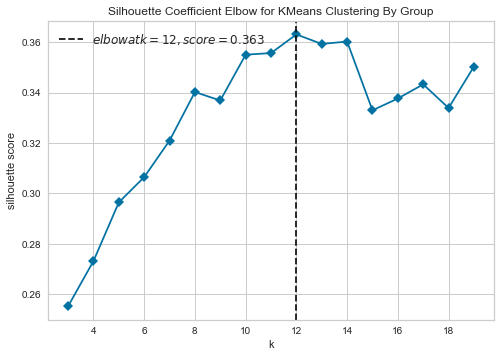

In [332]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
metric_val = 'silhouette'
visualizer = KElbowVisualizer(model, k=(3,20),title="Silhouette Coefficient Elbow for KMeans Clustering By Group", metric=metric_val,timings=False)
# , metric='calinski_harabasz','silhouette'
visualizer.fit(dfw_grouped_clustering_bygroup)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bygroup.png")

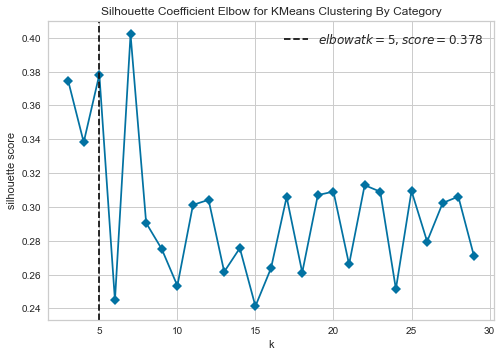

In [333]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,30),title="Silhouette Coefficient Elbow for KMeans Clustering By Category", metric=metric_val,timings=False)
visualizer.fit(dfw_grouped_clustering)
visualizer.show()
#visualizer.show(outpath="kelbow_visualizer_bycategory.png")